In [1]:
import scipy
import numpy as np
import h5py
import matplotlib.pyplot as plt
import bubblewrap

# Monkey Reach (Indy)
[source](https://zenodo.org/record/3854034)

In [78]:
fhan = h5py.File(bubblewrap.config.CONFIG["data_path"] / 'indy_20160407_02.mat', 'r')

In [79]:
# this is a first pass I'm using to find the first and last spikes
l = []
for j in range(fhan['spikes'].shape[1]):
    for i in range(fhan['spikes'].shape[0]):
        v = np.squeeze(fhan[fhan['spikes'][i,j]])
        if v[0] > 50: # empy channels have one spike very early while everything else is quiet
            l.append(v)

# this finds the first and last spikes in the dataset so we can set our bin boundaries
ll = [leaf for tree in l for leaf in tree]
stop = np.ceil(max(ll))
start = np.floor(min(ll))

# this creates the bins we'll use to group spikes
bin_width = .03 # units are seconds
bins = np.arange(start,stop, bin_width)
bin_centers = np.convolve([.5, .5], bins, "valid")

In [4]:
# columns of A are channels, rows are time bins
A = np.zeros(shape=(bins.shape[0]-1,len(l)))
c = 0 # we need this because some channels are empty
for j in range(fhan['spikes'].shape[1]):
    for i in range(fhan['spikes'].shape[0]):
        v = np.squeeze(fhan[fhan['spikes'][i,j]])
        if v[0] > 50:
                A[:, c],_ =  np.histogram(np.squeeze(fhan[fhan['spikes'][i,j]]), bins=bins)
            c += 1

In [10]:
np.squeeze(fhan[fhan['spikes'][1,1]]) # this is an array of spike times

array([ 60.06372324,  60.17832785,  60.29207227, ..., 887.61186779,
       887.6568413 , 887.73810492])

In [5]:
# load behavior data
raw_behavior = fhan['finger_pos'][:].T
t = fhan["t"][0]

# this resamples the behavior so it's in sync with the binned spikes
behavior = np.zeros((bin_centers.shape[0],raw_behavior.shape[1]))
for c in range(behavior.shape[1]):
    behavior[:,c] = np.interp(bin_centers, t, raw_behavior[:,c])
    

In [11]:
mask = bin_centers > 70 # behavior is near-constant before 70 seconds
bin_centers, behavior, A = bin_centers[mask], behavior[mask], A[mask] 

In [12]:
np.savez("indy_full.npz", y=A[None,:,:], x=behavior)

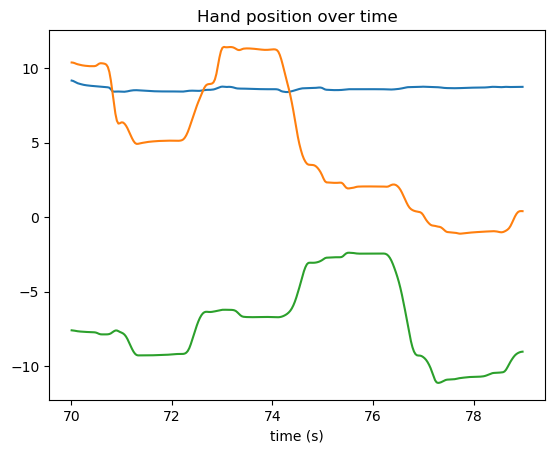

In [18]:
plt.plot(bin_centers[:300], behavior[:300]);
plt.title("Hand position over time");
plt.xlabel("time (s)");

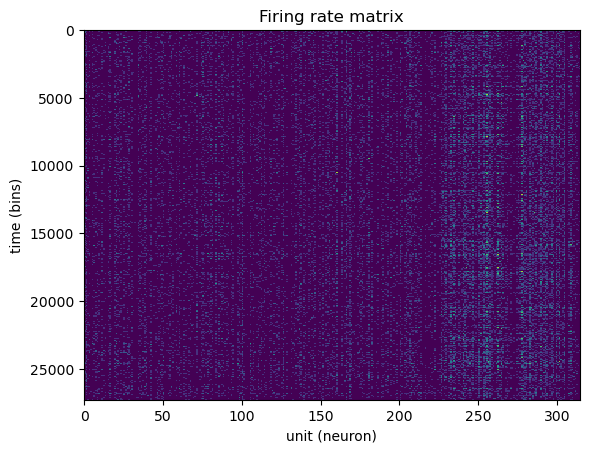

In [21]:
plt.imshow(A, aspect='auto', interpolation='nearest');
plt.title("Firing rate matrix");
plt.ylabel("time (bins)");
plt.xlabel("unit (neuron)");

100%|██| 80/80 [00:00<00:00, 1245.70it/s]


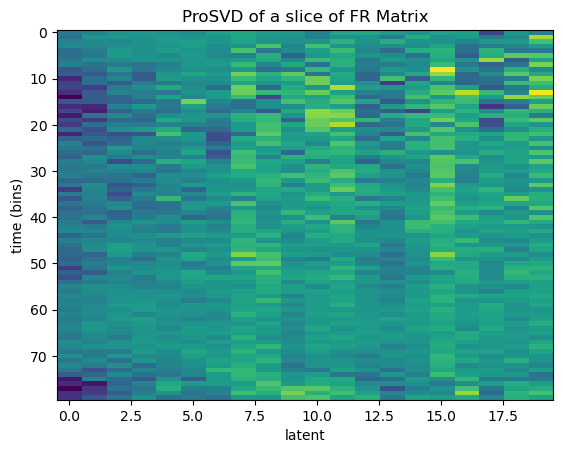

In [24]:
plt.imshow(bubblewrap.input_sources.functional.prosvd_data(A[1100:1200], 20, 20), aspect='auto', interpolation='nearest');
plt.xlabel("latent");
plt.title("ProSVD of a slice of FR Matrix");
plt.ylabel("time (bins)");

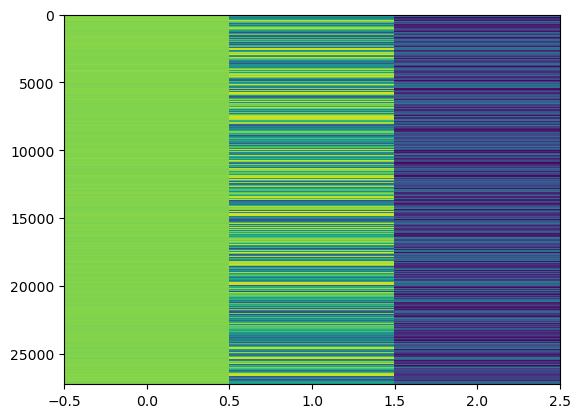

In [14]:
plt.imshow(behavior, aspect='auto', interpolation='nearest')

# Buzaki Lab data
[source](https://crcns.org/data-sets/thalamus/th-1/about-th-1)

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# mv /home/jgould/Downloads/Mouse*.tar.gz /home/jgould/Documents/Bubblewrap/generated/datasets/buzaki/
# !tar -xvf Mouse24-131216.tar.gz

In [50]:
cd /home/jgould/

/home/jgould


In [ ]:
ls

Mouse12-120806/  Mouse12-120807.tar.gz  Mouse24-131216.tar.gz
Mouse12-120807/  Mouse24-131216/        positions/


In [56]:
datasets = ["Mouse12-120806", "Mouse12-120807", "Mouse24-131216"]

In [52]:
def construct_buzaki_data(base, bin_size):
    parent_folder = bw.CONFIG["data_path"] / 'buzaki'
    def read_int_file(fname):
        with open(fname) as fhan:
            ret = []
            for line in fhan:
                line = int(line.strip())
                ret.append(line)
            return ret
        
    shanks = []
    for n in range(30):
        shanks.append(os.path.isfile(parent_folder / base / f"{base}.clu.{n}"))

    assert not any(shanks[20:])
    shanks = np.nonzero(shanks)[0]

    sampling_rate = 20_000
    clusters_to_ignore = {0,1}

    shank_datas = []
    cluster_mapping = {} # this will be a bijective dictionary between the (shank, cluster) and unit_number (also nan entries)

    min_time = float("inf")
    max_time = 0
    used_columns = 0
    for shank in shanks:
        clusters = read_int_file(parent_folder / base / f"{base}.clu.{shank}")
        n_clusters = clusters[0]
        clusters = clusters[1:]

        # TODO: check if I should exclude the hash unit
        for cluster in np.unique(clusters):
            if cluster not in clusters_to_ignore:
                cluster_mapping[(shank, cluster)] = used_columns
                used_columns += 1
                cluster_mapping[cluster_mapping[(shank, cluster)]] = (shank, cluster)
            else:
                cluster_mapping[(shank, cluster)] = np.nan


        clusters = [cluster_mapping[(shank,c)] for c in clusters]
        times = read_int_file(parent_folder / base / f"{base}.res.{shank}")

        pairs = np.array([times, clusters]).T
        pairs = pairs[~np.isnan(pairs[:,1]),:]

        if len(pairs):
            pairs[:,0] /= sampling_rate


            min_time = min(min_time, pairs[:,0].min())
            max_time = max(max_time, pairs[:,0].max())


            shank_datas.append(pairs)
            
    bins = np.arange(min_time, max_time + bin_size, bin_size)
    bin_centers = np.convolve([.5, .5], bins, "valid")
    A = np.zeros((len(bins)-1, used_columns ))

    for shank_data in shank_datas:
        max_lower_bound = 0
        last_time = 0
        for time, cluster in shank_data:
            assert time >= last_time
            while time > bins[max_lower_bound + 1]:
                max_lower_bound += 1
            A[max_lower_bound, int(cluster)] += 1
            last_time = time

    with open(parent_folder / base / f"{base}.whl", "r") as fhan:
        coords = [[] for _ in range(4)]
        for line in fhan:
            line = [float(x) for x in line[:-1].split("\t")]
            for i in range(4):
                coords[i].append(line[i])

    raw_behavior = np.array(coords).T

    sampling_rate = 39.06
    t = np.arange(raw_behavior.shape[0])/sampling_rate
    
    raw_behavior[raw_behavior == -1] = np.nan
    
    return A, raw_behavior, bin_centers, t

In [53]:
def resample_behavior(raw_behavior,bin_centers,t):
    good_samples = ~np.any(np.isnan(raw_behavior), axis=1)
    resampled_behavior = np.zeros((bin_centers.shape[0], raw_behavior.shape[1]))
    for c in range(resampled_behavior.shape[1]):
        resampled_behavior[:,c] = np.interp(bin_centers, t[good_samples], raw_behavior[good_samples,c])
    return resampled_behavior

In [61]:
A, raw_behavior, bin_centers, t = construct_buzaki_data(datasets[0], 0.03)

In [62]:
rbehavior = resample_behavior(raw_behavior, bin_centers, t)

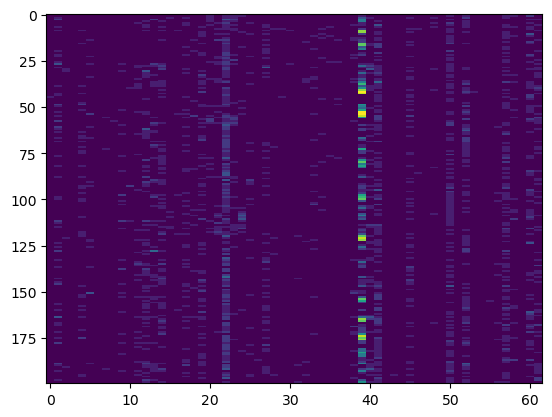

In [63]:
plt.imshow(A[:200], aspect='auto', interpolation='none')

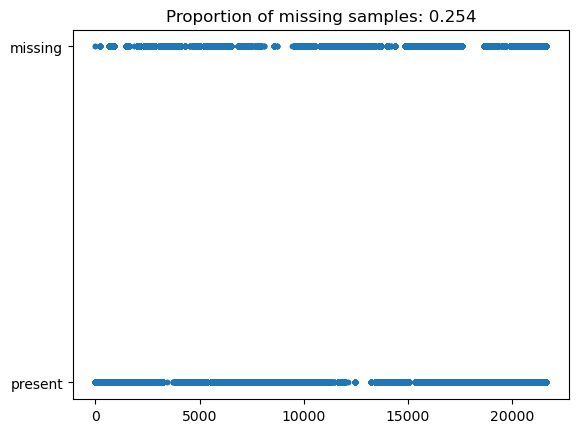

In [35]:
bad = np.any(raw_behavior==-1,axis=1)
plt.plot(t,bad, '.')
plt.yticks([0,1], labels=["present", "missing"])
plt.title(f"Proportion of missing samples: {bad.mean():.3f}");

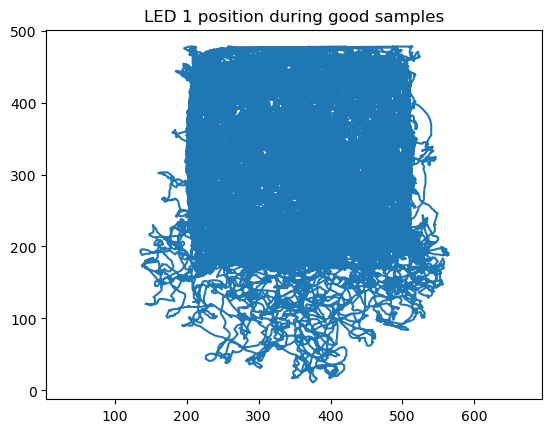

In [36]:
c = raw_behavior[~np.any(raw_behavior==-1,axis=1)]
plt.plot(c[:,0], c[:,1])
plt.axis("equal");
plt.title("LED 1 position during good samples");

In [16]:
hd = np.arctan2(resampled_behavior[:,0] - resampled_behavior[:,2], resampled_behavior[:,1] - resampled_behavior[:,3])

## Testing

In [83]:
rng = np.random.default_rng()

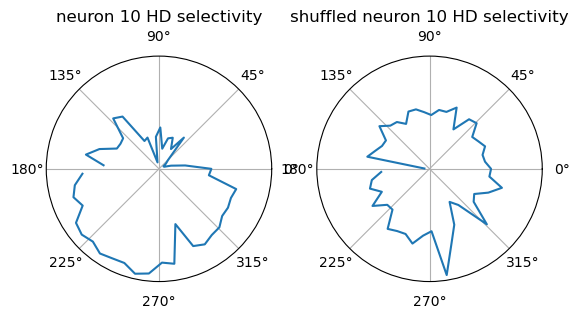

In [96]:
neuron = rng.integers(low=0, high=A.shape[1])
# neuron = 59
# neuron = 6
# neuron = 24

hd_bins = np.linspace(-np.pi, np.pi, 50)
hd_occupancy = np.histogram(hd, hd_bins)[0]
hd_centers = np.convolve(hd_bins, [.5, .5], 'valid')

counts = []
for i in range(len(hd_bins)-1):
    mask = (hd_bins[i] <= hd) & (hd < hd_bins[i+1])
    counts.append(A[mask,neuron].sum())
counts = counts/hd_occupancy

permutation1 = rng.permutation(len(A))
permutation2 = rng.permutation(len(hd))
shuf_counts = []
for i in range(len(hd_bins)-1):
    mask = (hd_bins[i] <= hd[permutation2]) & (hd[permutation2] < hd_bins[i+1])
    shuf_counts.append(A[permutation1[mask],neuron].sum())
shuf_counts = shuf_counts/hd_occupancy



fig, ax = plt.subplots(ncols=2,subplot_kw={'projection': 'polar'})

ax[0].plot(hd_centers, counts)
ax[0].grid(True)
ax[0].set_title(f"neuron {neuron} HD selectivity")
ax[0].set_rticks([]);

ax[1].plot(hd_centers, shuf_counts)
ax[1].grid(True)
ax[1].set_title(f"shuffled neuron {neuron} HD selectivity")
ax[1].set_rticks([]);

# Fly Data

In [1]:
import numpy as np
from pynwb import NWBHDF5IO
from IPython.display import display
import matplotlib.pyplot as plt
from nwbwidgets import nwb2widget
import glob
import bubblewrap as bw

In [2]:
pwd

'/home/jgould/Documents/Bubblewrap/generated/datasets'

In [3]:
base_path = bw.CONFIG["data_path"] / 'fly'

In [4]:
for file in sorted(base_path.glob("*.nwb")):
    with NWBHDF5IO(file, mode="r", load_namespaces=True) as fhan:
        nwbfile = fhan.read()
        n_roi = nwbfile.processing["ophys"].data_interfaces["DfOverF"].roi_response_series['RoiResponseSeries'].data.shape[1]
        n_beh = nwbfile.processing['behavioral state'].data_interfaces['behavioral state'].data.shape[1]
        print(f"{n_roi}\t{n_beh}\t{file.name}" )        

/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


2443	1	2018_08_24_fly2_run2.nwb
2170	1	2018_08_24_fly3_run1.nwb
1236	1	2019_04_18_fly2.nwb
1197	1	2019_04_22_fly1.nwb
1844	1	2019_04_22_fly3.nwb
1491	1	2019_04_24_fly1.nwb
2376	1	2019_04_24_fly3.nwb
1006	1	2019_04_25_fly1.nwb
1395	1	2019_04_25_fly3.nwb
1403	1	2019_04_26_fly1.nwb
1271	1	2019_04_29_fly1.nwb
1254	1	2019_05_07_fly1.nwb
19	1	2019_05_13_fly1.nwb
20	1	2019_05_14_fly3.nwb
22	1	2019_05_14_fly4.nwb
18	1	2019_05_20_fly2.nwb
21	1	2019_05_20_fly3.nwb
1497	6	2019_06_28_fly2.nwb
1559	6	2019_07_01_fly2.nwb
1130	6	2019_08_07_fly2.nwb
1688	6	2019_08_14_fly1.nwb
1202	6	2019_08_14_fly2.nwb
1146	6	2019_08_14_fly3_2.nwb
874	6	2019_08_20_fly2.nwb
851	6	2019_08_20_fly3.nwb
1648	6	2019_10_02_fly2.nwb
1811	6	2019_10_10_fly3.nwb
1095	6	2019_10_14_fly2.nwb
1672	6	2019_10_14_fly3.nwb
1171	6	2019_10_14_fly4.nwb
883	6	2019_10_18_fly2.nwb
1134	6	2019_10_18_fly3.nwb
1316	6	2019_10_21_fly1.nwb
12	1	2019_11_12_fly5.nwb
15	1	2019_11_12_fly6.nwb
14	6	2020_07_29_fly2.nwb
10	6	2020_08_10_fly1.nwb
13	1	2020_

/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/pynwb/ophys.py:445: UserWarning: RoiResponseSeries 'RoiResponseSeries': The second dimension of data does not match the length of rois. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of rois. "


In [6]:
for file in sorted(base_path.glob("*.nwb")):
    with NWBHDF5IO(file, mode="r", load_namespaces=True) as fhan:
        nwbfile = fhan.read()
        n_roi = nwbfile.processing["ophys"].data_interfaces["DfOverF"].roi_response_series['RoiResponseSeries'].data.shape[1]
        n_beh = nwbfile.shape[1]
        if n_beh == 6 and n_roi > 200:
            print(file.name)        

AttributeError: 'NWBFile' object has no attribute 'shape'

In [9]:
datasets = """2019_06_28_fly2.nwb
2019_07_01_fly2.nwb
2019_08_07_fly2.nwb
2019_08_14_fly1.nwb
2019_08_14_fly2.nwb
2019_08_14_fly3_2.nwb
2019_08_20_fly2.nwb
2019_08_20_fly3.nwb
2019_10_02_fly2.nwb
2019_10_10_fly3.nwb
2019_10_14_fly2.nwb
2019_10_14_fly3.nwb
2019_10_14_fly4.nwb
2019_10_18_fly2.nwb
2019_10_18_fly3.nwb
2019_10_21_fly1.nwb"""

datasets = datasets.strip().split("\n")
datasets

['2019_06_28_fly2.nwb',
 '2019_07_01_fly2.nwb',
 '2019_08_07_fly2.nwb',
 '2019_08_14_fly1.nwb',
 '2019_08_14_fly2.nwb',
 '2019_08_14_fly3_2.nwb',
 '2019_08_20_fly2.nwb',
 '2019_08_20_fly3.nwb',
 '2019_10_02_fly2.nwb',
 '2019_10_10_fly3.nwb',
 '2019_10_14_fly2.nwb',
 '2019_10_14_fly3.nwb',
 '2019_10_14_fly4.nwb',
 '2019_10_18_fly2.nwb',
 '2019_10_18_fly3.nwb',
 '2019_10_21_fly1.nwb']

In [ ]:
bw.

In [25]:
io = NWBHDF5IO(base_path / '2019_08_20_fly2.nwb', mode="r", load_namespaces=True)
nwbfile = io.read()
nwb2widget(nwbfile)

/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


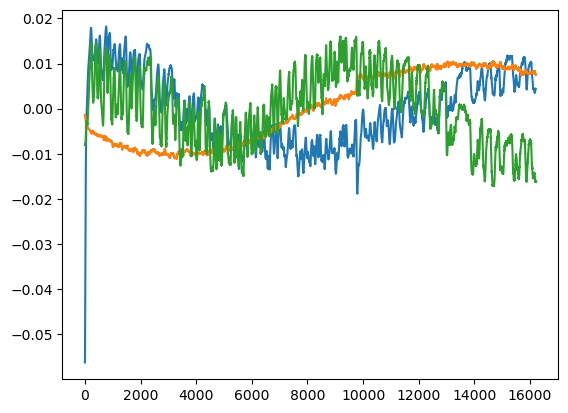

In [26]:


A -= A.mean(axis=0)
A /= A.std(axis=0, ddof=1)
u, s, vh = np.linalg.svd(A, full_matrices=False)

plt.plot(u[:,:3])

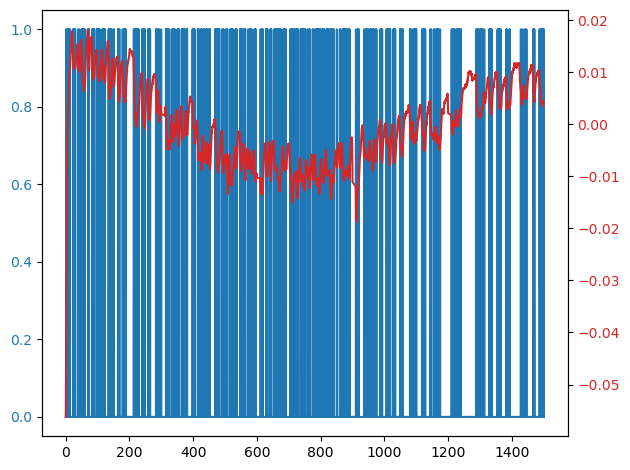

In [7]:
fig, ax2 = plt.subplots()

color = 'tab:blue'
ax2.plot(t, beh, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1 = ax2.twinx()


color = 'tab:red'
ax1.plot(t, u[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

# Mouse Video

In [1]:
import h5py
import bubblewrap
import numpy as np
import os
import matplotlib.pyplot as plt
import urllib.request
from bubblewrap import CONFIG

/home/jgould/Documents/Bubblewrap/generated/datasets/musal


### Widefield

In [3]:
# https://labshare.cshl.edu/shares/library/repository/38599/Widefield/mSM30/10-Oct-2017/mSM30_SpatialDisc_Oct10_2017_Session1.mat

In [4]:
base = "https://labshare.cshl.edu/shares/library/repository/38599/Widefield/mSM30/10-Oct-2017/"
import urllib.request

fname = "Vc.mat"
if not os.path.exists(fname):
    urllib.request.urlretrieve(f"{base}/{fname}", fname)

In [5]:
fhan = h5py.File(CONFIG["data_path"] / "musal" / "their_data" / , 'r')

In [6]:
for key in fhan:
    if hasattr(fhan[key], 'shape'):
        print(f"{key} {fhan[key].shape}")

Sv (1, 500)
U (200, 640, 540)
Vc (395, 205, 200)
bTrials (395, 1)
blueFrametimes (395, 205)
totalVar (1, 1)
trials (395, 1)


In [7]:
U = fhan["U"][:]
Vc = fhan["Vc"][:]

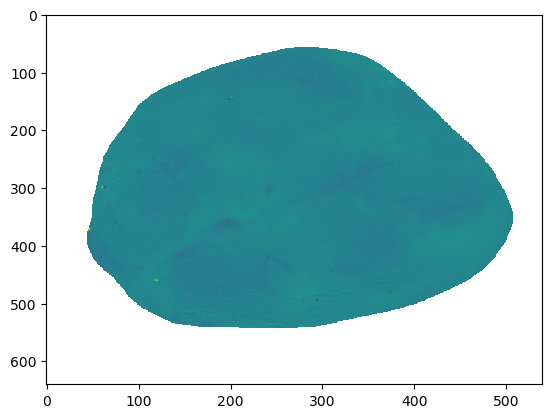

In [8]:
plt.imshow(U[40,:,:],aspect='auto')

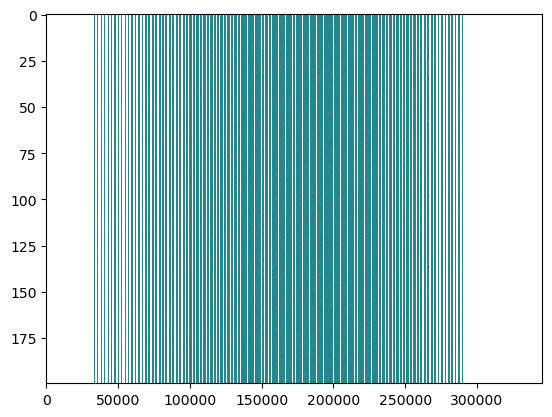

In [9]:
UU = U.reshape(U.shape[0], -1)
plt.imshow(UU, aspect='auto', interpolation='none')

In [10]:
VVc = Vc.reshape(-1, Vc.shape[-1])

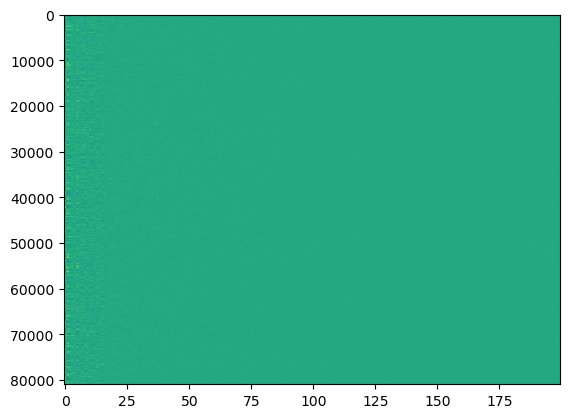

In [11]:
plt.imshow(VVc, aspect='auto', interpolation='none')

In [12]:
U.shape

(200, 640, 540)

In [58]:
VVc.shape, UU.shape

((80975, 200), (200, 345600))

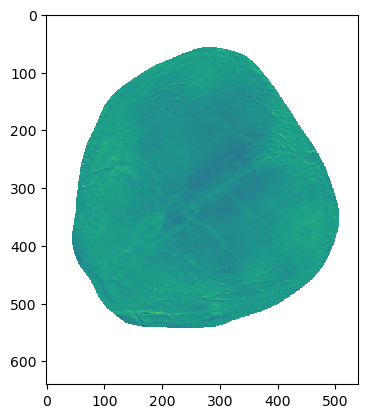

In [13]:
test_frames = VVc[:3,:] @ UU
test_frames = test_frames.reshape([-1,U.shape[-2], U.shape[-1]])
plt.imshow(test_frames[0,:,:])

### 2p

In [1]:
from scipy.io import loadmat
import bubblewrap
import numpy as np
import os
import matplotlib.pyplot as plt
import urllib
from bubblewrap import CONFIG
import h5py
from skimage.transform import resize
from tqdm import tqdm
import bubblewrap.input_sources.functional as fin

In [6]:
ca, vid, t_ca, t_vid = fin.generate_musal_dataset(cam=2, video_target_dim=100, resize_factor=1, prosvd_init_size=100)

In [7]:
ca, vid, t_ca, t_vid = fin.generate_musal_dataset(cam=1, video_target_dim=10, resize_factor=1, prosvd_init_size=100)

In [65]:
trial_edges.astype(int)

array([[    9,   213],
       [  255,   460],
       [  494,   699],
       [  739,   944],
       [  986,  1191],
       [ 1393,  1597],
       [ 1622,  1827],
       [ 1868,  2073],
       [ 2100,  2304],
       [ 2491,  2696],
       [ 2731,  2936],
       [ 2992,  3197],
       [ 3223,  3427],
       [ 3459,  3664],
       [ 3710,  3915],
       [ 3959,  4164],
       [ 4209,  4414],
       [ 4443,  4648],
       [ 4683,  4888],
       [ 4933,  5138],
       [ 5155,  5360],
       [ 5385,  5590],
       [ 5612,  5817],
       [ 5846,  6051],
       [ 6075,  6279],
       [ 6313,  6518],
       [ 6550,  6755],
       [ 6779,  6984],
       [ 7011,  7216],
       [ 7241,  7446],
       [ 7478,  7683],
       [ 7712,  7917],
       [ 7941,  8146],
       [ 8176,  8381],
       [ 8409,  8613],
       [ 8633,  8838],
       [ 8870,  9075],
       [ 9100,  9304],
       [ 9352,  9557],
       [ 9584,  9789],
       [ 9825, 10030],
       [10057, 10262],
       [10301, 10506],
       [105

In [64]:
trial_edges.shape

(362, 2)

In [3]:
data_dir = CONFIG["data_path"] / "musal/their_data/2pData/Animals/mSM49/SpatialDisc/30-Jul-2018/"
variables = loadmat(data_dir/"data.mat",  squeeze_me=True, simplify_cells=True)
A = variables["data"]['dFOF']

A = np.vstack(A.T)

(78554,)

In [79]:
A.shape

(78554, 57)

In [77]:
Data.shape

(89831, 320, 240)

(57, 217, 362)

In [58]:
trial_edges.shape

(363, 2)

In [50]:
A.shape

(78554, 57)

In [55]:
np.linspace(*trial_edges[i],10)

array([739.        , 761.77777778, 784.55555556, 807.33333333,
       830.11111111, 852.88888889, 875.66666667, 898.44444444,
       921.22222222, 944.        ])

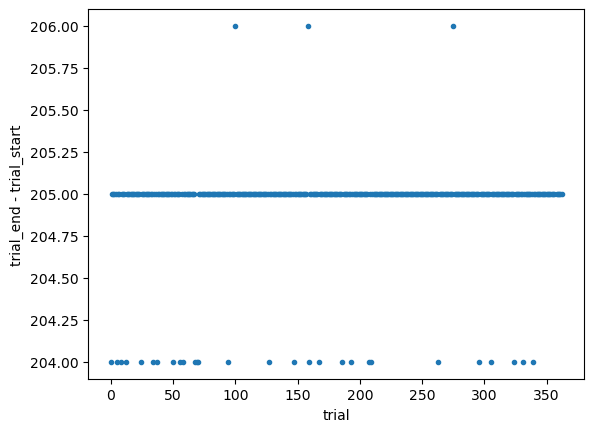

In [51]:
%matplotlib inline
plt.plot(trial_edges[:,1] - trial_edges[:,0], '.')
plt.ylabel("trial_end - trial_start")
plt.xlabel("trial");

100%|███████████████████████████████████████████████████| 16/16 [05:14<00:00, 19.63s/it]


In [46]:
?

Signature: fin.prosvd_data(input_arr, output_d, init_size)
Docstring: <no docstring>
File:      ~/Documents/Bubblewrap/bubblewrap/input_sources/functional.py
Type:      function

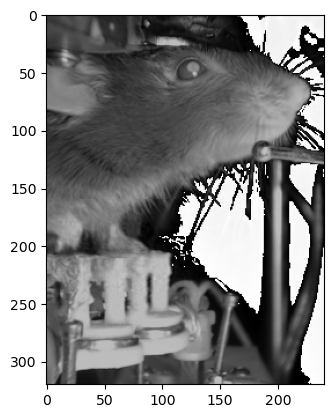

In [43]:
d = Data[:10]

e = d.reshape(d.shape[0], -1)

e =e + np.arange(e.shape[0])[:,None] * 30
e %= 255
e = e.reshape(d.shape)
plt.imshow(e[7], cmap='gray')

### Beh

In [11]:
# base = "https://labshare.cshl.edu/shares/library/repository/38599/2pData/Animals/mSM60/SpatialDisc/06-Sep-2018/"


fname = 'mSM60_SpatialDisc_Sep06_2018_Session1.mat'
eventual_path = bubblewrap.config.CONFIG["data_path"] / "musal" /  fname
if not os.path.exists(eventual_path):
    urllib.request.urlretrieve(f"{base}{fname}", eventual_path)

In [13]:
base = "https://labshare.cshl.edu/shares/library/repository/38599/2pData/Animals/mSM60/SpatialDisc/06-Sep-2018/"
base = base + "BehaviorVideo/"
# https://labshare.cshl.edu/shares/library/repository/38599/2pData/Animals/mSM60/SpatialDisc/06-Sep-2018/
fname = 'SVD_CombinedSegments.mat'
eventual_path = bubblewrap.config.CONFIG["data_path"] / "musal" /  fname
if not os.path.exists(eventual_path):
    urllib.request.urlretrieve(f"{base}{fname}", eventual_path)

In [14]:
fhan = loadmat(eventual_path, squeeze_me=True, simplify_cells=True)

In [43]:
fhan['allTimes'][0].shape

(121473,)

In [44]:
fhan['allTimes'][1].shape

(122763,)

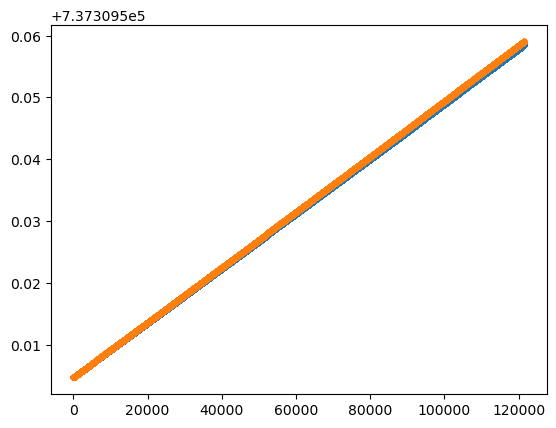

In [56]:
plt.plot(fhan['allTimes'][1][:121473], '.')
plt.plot(fhan['allTimes'][0][:121473], '.')

(121473,)

In [15]:
for key in fhan:
    if hasattr(fhan[key], 'shape'):
        print(f"{key} {fhan[key].shape}")

allTimes (2,)
vidU (500, 16000)
meanV (500,)
stdV (500,)
vidV (103730, 500)


In [16]:
vidV = fhan['vidV']

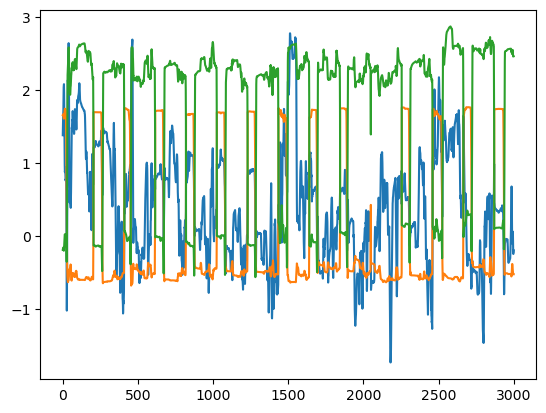

In [17]:
plt.plot(vidV[:3000,0:3])

In [18]:
vidV.shape

(103730, 500)

In [19]:
fhan["vidU"].shape

(500, 16000)

In [ ]:
1600

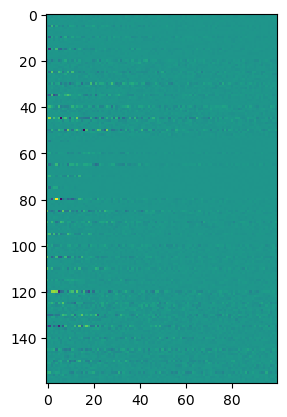

In [35]:
plt.imshow((vidV[0,:] @ fhan['vidU']).reshape(160,100), interpolation='none')

In [29]:
16000 == 4*4*5*2*10*10

True